In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from utils_1 import FILE_RESULTS as ST2
from utils_1 import VALIDATION_COMPARISON


PALETTE_PARAMS='Accent'
PALETTE='Set2'

These combinations of m and sd:
[(0.05, 0.001), (0.05, 0.01), (0.5, 0.01), (0.5, 0.1)]
These combinations of gv and alpha:
[(0, 0),
 (0, 0.5),
 (0.1, 0),
 (0.1, 0.5),
 (0.5, 0),
 (0.5, 0.5),
 (0.9, 0),
 (0.9, 0.5),
 (1, 0),
 (1, 0.5)]
These combinations of theta and pIndep:
[(0, 1), (0.5, 0.5), (1, 0)]


## Intro variables

In [2]:
ct_name = "Total"  # found clumps total
cc_name = "Precision"  # ratio of clumps, which contains causal
cnc_name = "FDR"
sf_name = "Recall"  # ratio of correctly predicted clumps among all causal snps 
snf_name = "FNR"

column_names = {
    "m/sd": "m_beta / sd_beta",
    "m_beta": "effect size (m_beta)",
    "sd_beta": "standard deviation of effect size (sd_beta)",
    "gen_var": "genetic effects variance (gen_var)",
    "alpha": "variance of shared observational noise effect (alpha)",
    "theta": "proportion of variance\nof shared genetic variant effects (theta)",
    "pIndep": "proportion of genetic variant effects\nto have a trait-independent fixed effect (pIndependent)",
    "K": "amount of causal SNPs (K); k=K/2",
    "_":"",
    'gv/K':"gen.var./K"
}
# m_beta – effect size, sd_beta – standard deviation of effect size, gen_var – наследственная изменчивость, h2s – доля изменчивости, объясняемая причинными SNP.

In [3]:
', '.join(column_names.values())

'm_beta / sd_beta, effect size (m_beta), standard deviation of effect size (sd_beta), genetic effects variance (gen_var), variance of shared observational noise effect (alpha), proportion of variance\nof shared genetic variant effects (theta), proportion of genetic variant effects\nto have a trait-independent fixed effect (pIndependent), amount of causal SNPs (K); k=K/2, , gen.var./K'

## Data

read dataset of clumped snps with metrics

In [4]:
data = pd.read_csv(ST2, sep='\t').rename(columns={'clumps_causal':cc_name, 'clumps_not_causal':cnc_name, "causal_found": sf_name, "causal_not_found": snf_name, 'clumps_total': ct_name})
data['F1'] = 2/(1/data.Precision+1/data.Recall)
data['m/sd']= np.round(data['m_beta']/data['sd_beta'], 3)
data['gv/K']= np.round(data['gen_var']/data['K'], 3)
data

,K,m_beta,sd_beta,gen_var,alpha,theta,pIndep,Total,Precision,FDR,Recall,FNR,F1,m/sd,gv/K
0,10,0.05,0.001,0.0,0.0,0.0,1.0,0,0.00000,0.00000,0.0,1.0,0.000000,50.0,0.000
1,20,0.05,0.001,0.0,0.0,0.0,1.0,0,0.00000,0.00000,0.0,1.0,0.000000,50.0,0.000
2,30,0.05,0.001,0.0,0.0,0.0,1.0,0,0.00000,0.00000,0.0,1.0,0.000000,50.0,0.000
3,10,0.05,0.001,0.0,0.0,0.5,0.5,0,0.00000,0.00000,0.0,1.0,0.000000,50.0,0.000
4,20,0.05,0.001,0.0,0.0,0.5,0.5,0,0.00000,0.00000,0.0,1.0,0.000000,50.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,20,0.50,0.100,1.0,0.5,0.5,0.5,159,0.11950,0.88050,1.0,0.0,0.213488,5.0,0.050
356,30,0.50,0.100,1.0,0.5,0.5,0.5,175,0.17143,0.82857,1.0,0.0,0.292685,5.0,0.033
357,10,0.50,0.100,1.0,0.5,1.0,0.0,255,0.03922,0.96078,1.0,0.0,0.075480,5.0,0.100
358,20,0.50,0.100,1.0,0.5,1.0,0.0,158,0.12025,0.87975,1.0,0.0,0.214684,5.0,0.050


## Aggregate by K

In [5]:
# List of K values to process
K_values = [10, 20, 30]

# Creating an empty DataFrame for the merged results
merged_df = pd.DataFrame()

data['F1'] = 2/(1/data.Precision+1/data.Recall)

f1_cols = []

# Looping through each K value
for K in K_values:
    # Filtering the DataFrame for the current K value
    df_filtered = data[data['K'] == K][['m_beta', 'sd_beta', 'gen_var', 'alpha', 'theta', 'pIndep', 'Total', 'Precision', 'FDR', 'Recall', 'FNR', 'F1']]
    
    # Renaming the columns to include the K value
    df_filtered.rename(columns=lambda x: x + f' (K={K})' if x not in ['m_beta', 'sd_beta', 'gen_var', 'alpha', 'theta', 'pIndep'] else x, inplace=True)
    
    # Merging with the main DataFrame
    if merged_df.empty:
        merged_df = df_filtered
    else:
        merged_df = pd.merge(merged_df, df_filtered, on=['m_beta', 'sd_beta', 'gen_var', 'alpha', 'theta', 'pIndep'], how='outer')
    # save names of f1
    f1_cols.append(f'F1 (K={K})')
        

merged_df['F1_avg']=merged_df[f1_cols].mean(axis=1)
merged_df.to_csv(VALIDATION_COMPARISON, sep=',', index=False)
merged_df

,m_beta,sd_beta,gen_var,alpha,theta,pIndep,Total (K=10),Precision (K=10),FDR (K=10),Recall (K=10),...,Recall (K=20),FNR (K=20),F1 (K=20),Total (K=30),Precision (K=30),FDR (K=30),Recall (K=30),FNR (K=30),F1 (K=30),F1_avg
0,0.05,0.001,0.0,0.0,0.0,1.0,0,0.00000,0.00000,0.0,...,0.0,1.0,0.000000,0,0.00000,0.00000,0.0,1.0,0.000000,0.000000
1,0.05,0.001,0.0,0.0,0.5,0.5,0,0.00000,0.00000,0.0,...,0.0,1.0,0.000000,0,0.00000,0.00000,0.0,1.0,0.000000,0.000000
2,0.05,0.001,0.0,0.0,1.0,0.0,0,0.00000,0.00000,0.0,...,0.0,1.0,0.000000,0,0.00000,0.00000,0.0,1.0,0.000000,0.000000
3,0.05,0.001,0.0,0.5,0.0,1.0,0,0.00000,0.00000,0.0,...,0.0,1.0,0.000000,0,0.00000,0.00000,0.0,1.0,0.000000,0.000000
4,0.05,0.001,0.0,0.5,0.5,0.5,0,0.00000,0.00000,0.0,...,0.0,1.0,0.000000,0,0.00000,0.00000,0.0,1.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.50,0.100,1.0,0.0,0.5,0.5,291,0.03436,0.96564,1.0,...,1.0,0.0,0.213488,175,0.17143,0.82857,1.0,0.0,0.292685,0.190870
116,0.50,0.100,1.0,0.0,1.0,0.0,255,0.03922,0.96078,1.0,...,1.0,0.0,0.214684,178,0.16854,0.83146,1.0,0.0,0.288463,0.192875
117,0.50,0.100,1.0,0.5,0.0,1.0,255,0.03922,0.96078,1.0,...,1.0,0.0,0.214684,178,0.16854,0.83146,1.0,0.0,0.288463,0.192875
118,0.50,0.100,1.0,0.5,0.5,0.5,291,0.03436,0.96564,1.0,...,1.0,0.0,0.213488,175,0.17143,0.82857,1.0,0.0,0.292685,0.190870


## Precision-recall scatter plot

In [6]:
d = data

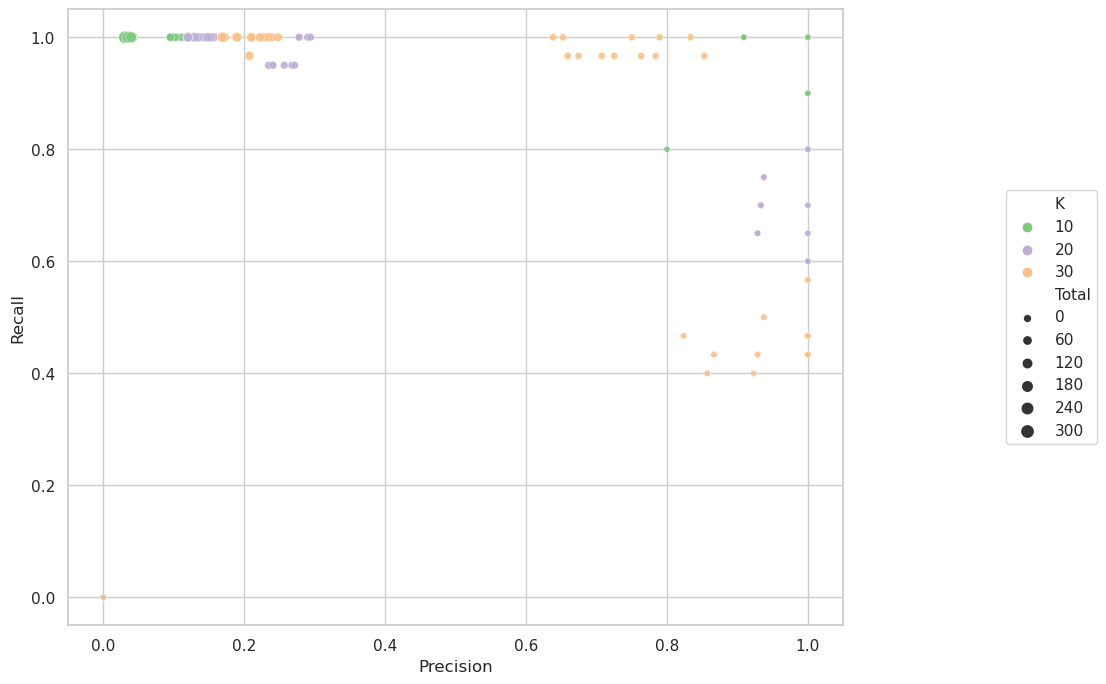

In [7]:
sns.set()
plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid")
ax = sns.scatterplot(d, 
                     x='Precision', 
                     y='Recall', 
                     hue='K', 
                     size=ct_name, 
                     palette=PALETTE_PARAMS,  
                     alpha=.7,)
ax.set(xlabel=cc_name, ylabel=sf_name)

plt.plot([], [], ' ')

plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))
plt.savefig('images/SF4.1.pdf')
plt.show()

## Distributions of precision and recall relatively to params

In [8]:
def draw_violins(d, cur_y, cur_name, columns, name = '', min_y=-0.05, max_y=1.05):
    sns.set(rc={"figure.figsize": (15, 10)})
    sns.set_theme(style="whitegrid")
    # get legend
    ax = sns.violinplot(d, 
                        x=columns[0], 
                        y=cur_y, 
                        palette=PALETTE_PARAMS,
                        hue='K')
    handles, labels = ax.get_legend_handles_labels()
    plt.clf()
    # draw
    fig, axs = plt.subplots(nrows=2, ncols=2)
    for i, c in enumerate(columns):
        if c=='_':
            continue
        row = i // 2
        col = i % 2
        ax = sns.stripplot(d, 
                            x=c, 
                            y=cur_y, 
                            hue='K', 
                            palette=PALETTE_PARAMS,
                            alpha=.7,
                            ax=axs[row][col], 
                            legend=False, 
                           dodge=True
                           )
        
        ax = sns.violinplot(d, 
                            x=c, 
                            y=cur_y, 
                            hue='K', 
                            palette=PALETTE_PARAMS,
                            alpha=.7,
                            ax=axs[row][col], 
                            legend=False, 
                            cut=0
                           )
        plt.setp(ax.collections, alpha=.58)
        ax.legend_.remove()
        ax.set(ylabel='', xlabel=column_names[c])
        ax.set(ylim=(min_y, max_y))
        ax
    fig.supylabel(cur_name, y=0.5, x=0.07)
    fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.9, 0.5), title=column_names['K'])
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
    if name != '':
        plt.savefig(name)
    plt.show()

In [9]:
columnses = [["m_beta", "sd_beta", "m/sd", "gen_var"], 
            ["alpha","theta","pIndep",'gv/K',]]

<Figure size 1500x1000 with 0 Axes>

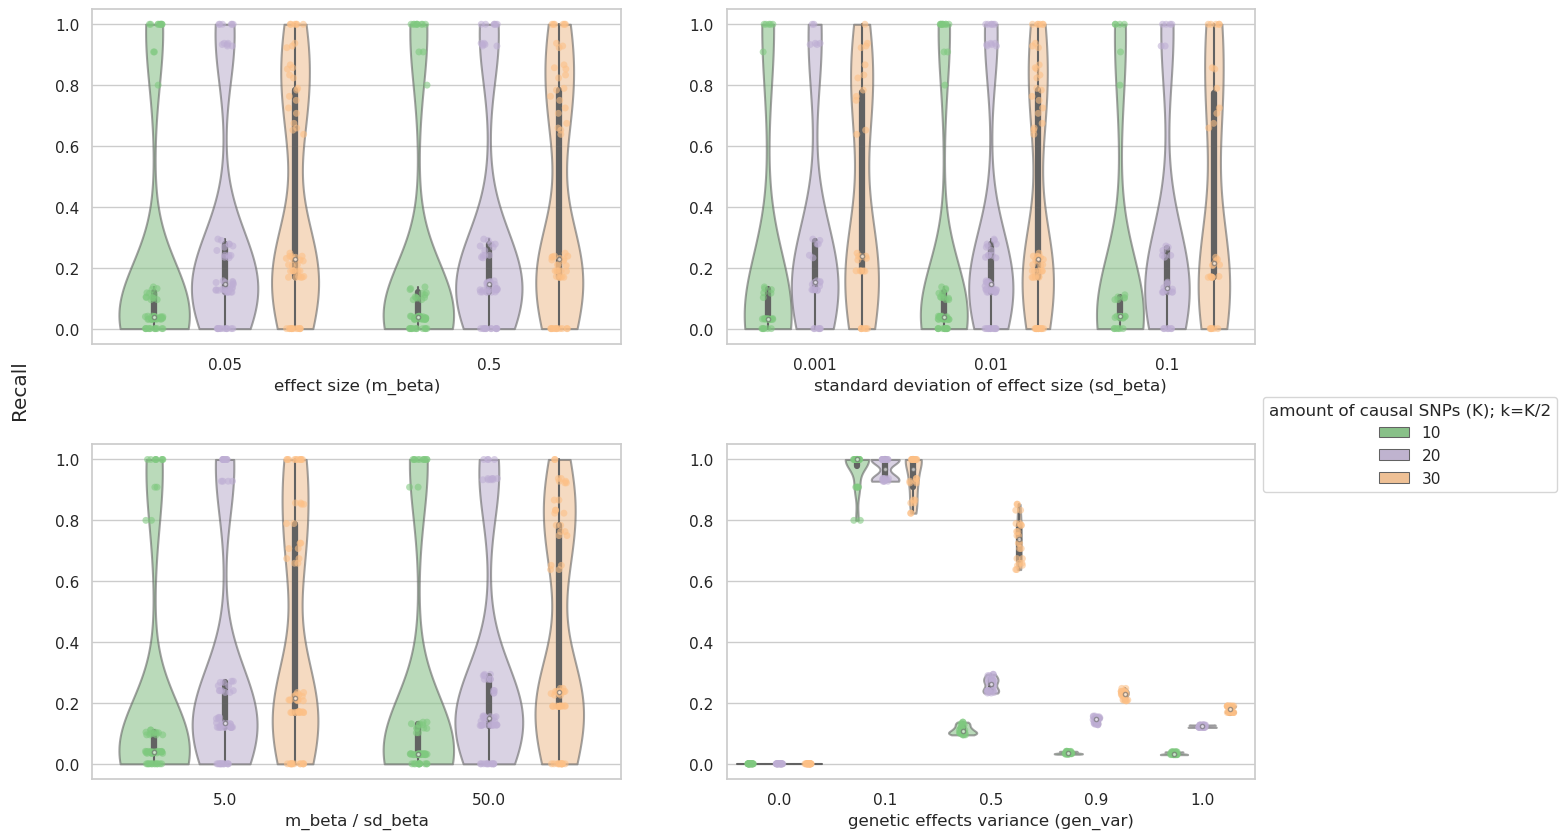

<Figure size 1500x1000 with 0 Axes>

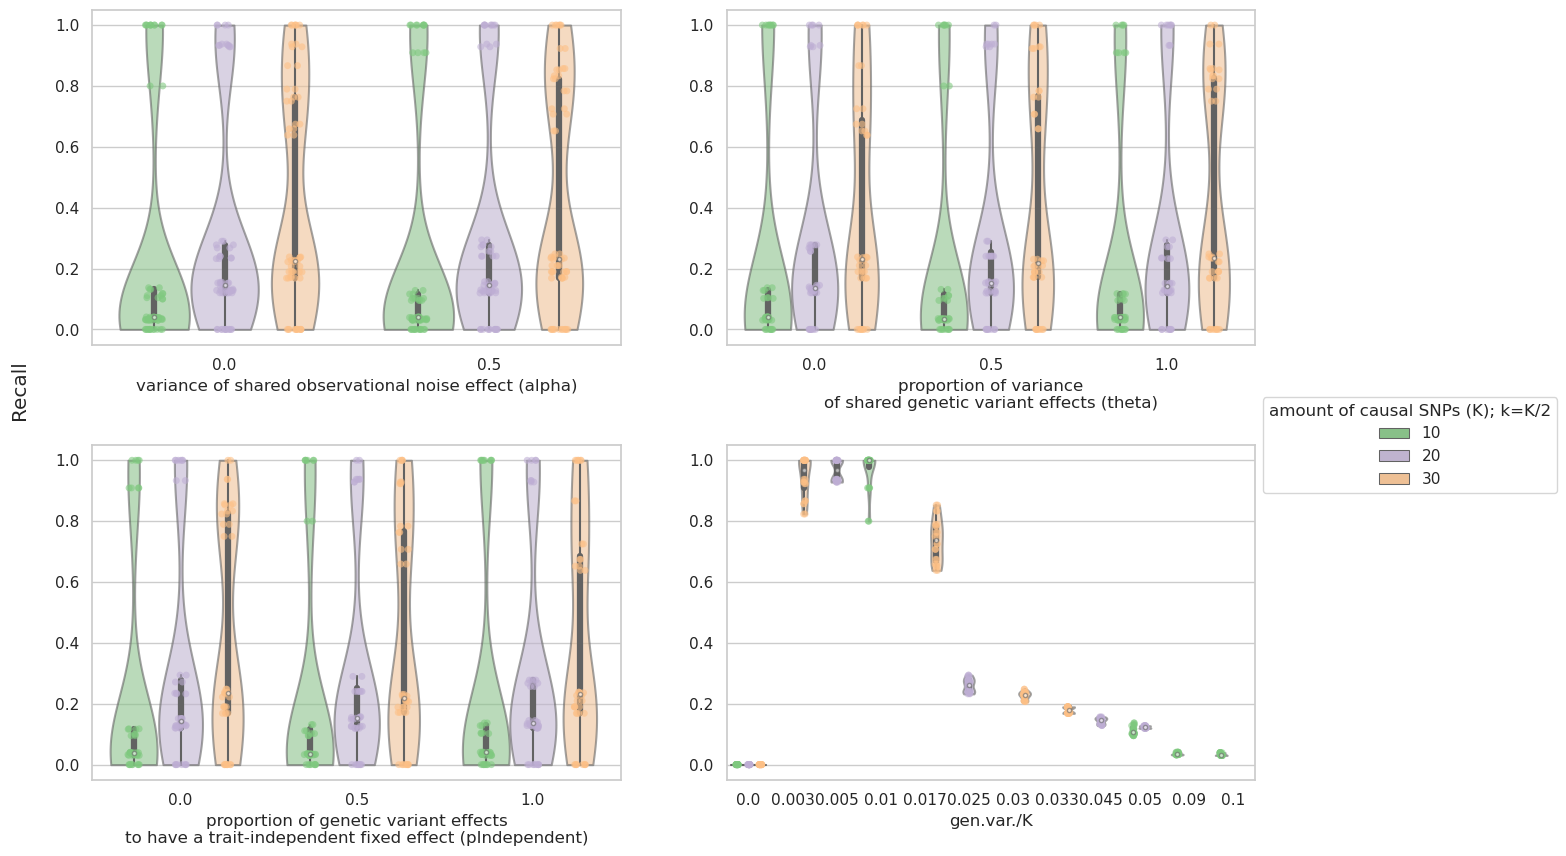

<Figure size 1500x1000 with 0 Axes>

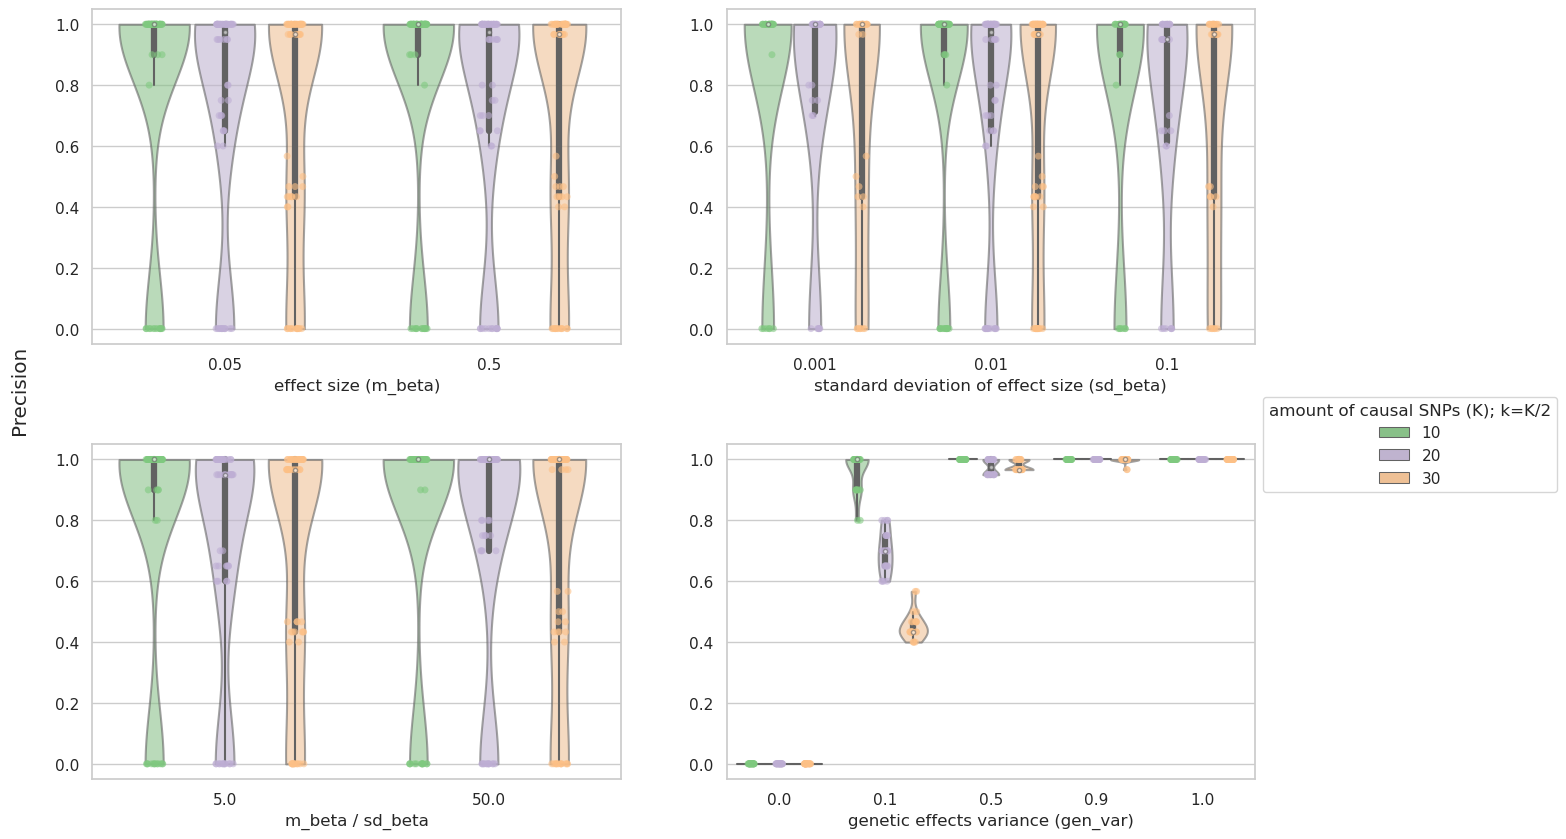

<Figure size 1500x1000 with 0 Axes>

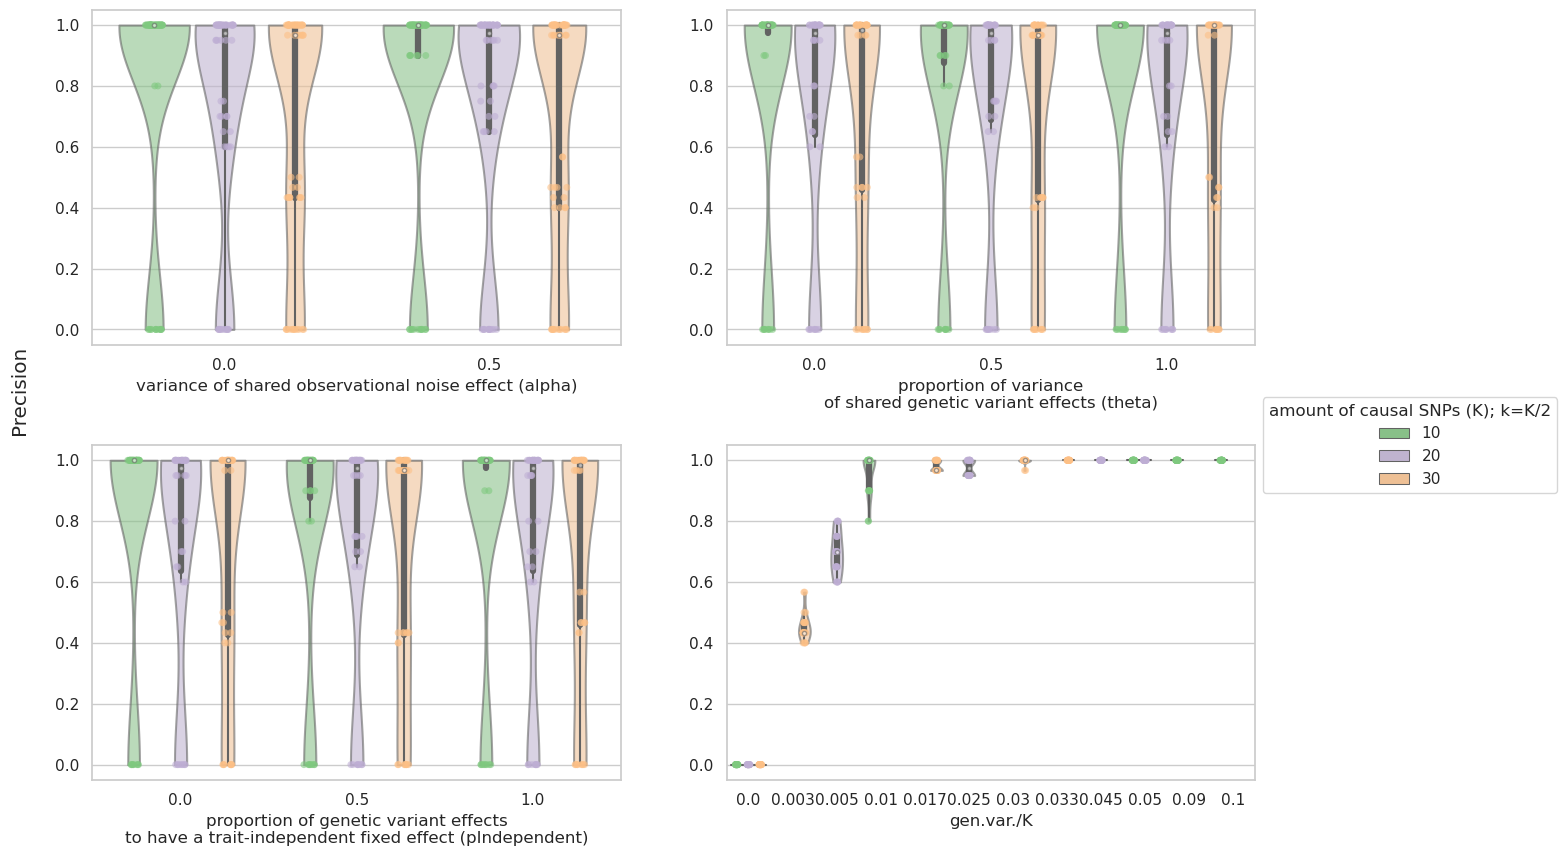

<Figure size 1500x1000 with 0 Axes>

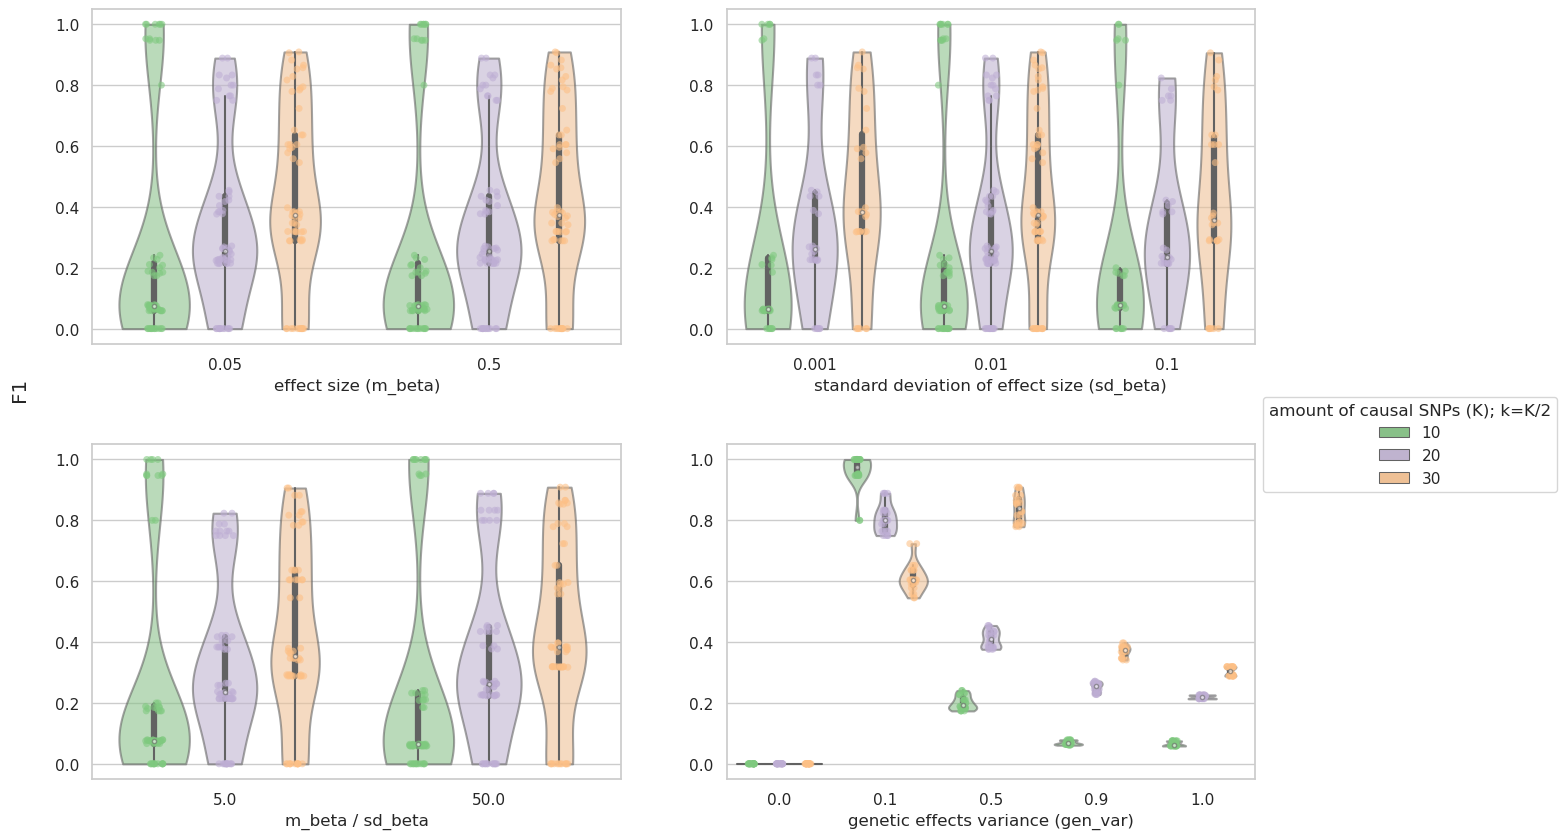

<Figure size 1500x1000 with 0 Axes>

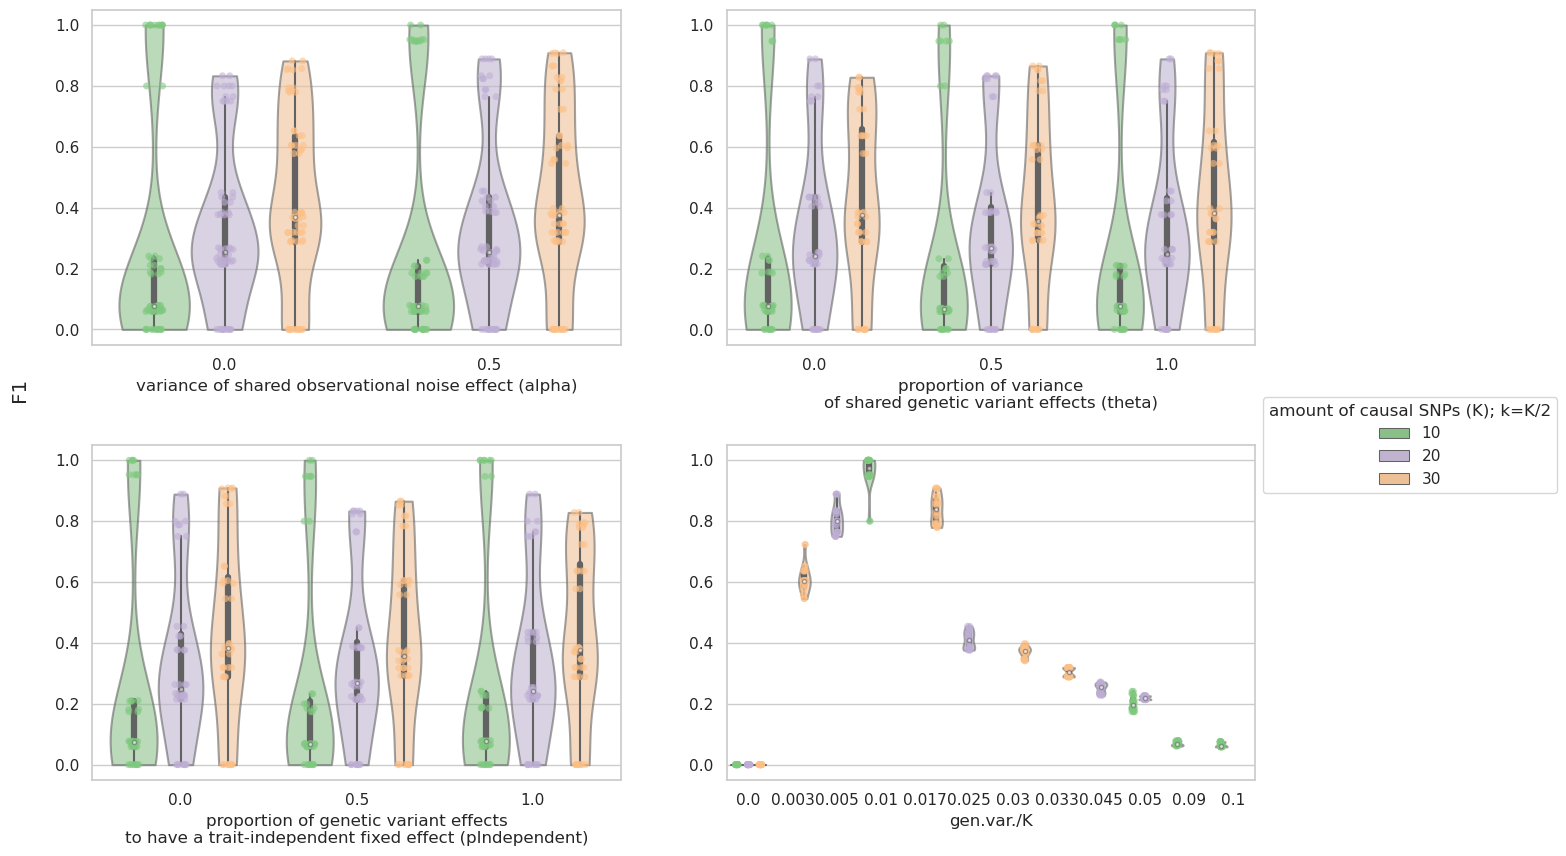

In [10]:
cur_ys = ['Precision', 'Recall', 'F1']
cur_names = [sf_name, cc_name, 'F1']

i=1
for cur_y, cur_name in zip(cur_ys, cur_names):
    for columns in columnses:
        name=f'images/SF3.{i}.pdf'
        i+=1
        draw_violins(d, cur_y, cur_name, columns, name=name)